# Agtuary ML Challenge - Inference

This notebook uses a pre-trained model selected from a field of candidates to perform inference as part of the [Agtuary ML Challenge](https://github.com/agtuary/machine-learning-challenge).


Looking at the final output image (below and saved as Inference.png), there are areas characterised by noise, where the model has predicted a mix of crop types. As expected from training and validation, the mixed crop type areas mostly constitute Sorghum and Other, although a small number of areas contain Cotton pixels, too. Noise often occurs on the edges of objects, suggesting that the model may have difficulty characterising crop borders. Implementing an object-based detection approach could help to reduce this kind of noise.

In [1]:
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, cohen_kappa_score, make_scorer
from sklearn.neural_network import MLPClassifier

import os
import glob
import pickle

pd.options.mode.chained_assignment = None

In [2]:
#!pip install seaborn
import seaborn

In [3]:
def load_image(path):
    return np.array(PIL.Image.open(path))[:, :]

In [4]:
def load_model(filename, folder):
    print(f"Checking if '{filename}' exists in '{folder}'...")
    file_path = os.path.join(folder, filename)
    if os.path.exists(file_path) is True:
        print(f"Loading '{filename}'")
        with open(file_path, 'rb') as f:
            model = pickle.load(f)
        print(f"'{filename}' loaded.")
        return model
    else: 
        print(f"Cannot load model: '{filename}' does not exist.")

In [5]:
# get the current working directory
path = os.getcwd()
print(path)

/home/lachy/dml/agtuary-machine-learning-challenge-master


In [6]:
# get location of data subfolder
subfolder = "data_raw"
data_dir = os.path.join(path, subfolder)
print(data_dir)

/home/lachy/dml/agtuary-machine-learning-challenge-master/data_raw


In [7]:
# get location of models subfolder
subfolder = "models"
models_dir = os.path.join(path, subfolder)
print(models_dir)

/home/lachy/dml/agtuary-machine-learning-challenge-master/models


In [8]:
label_mapper = {0: 'Other', 1:'Sorghum', 2:'Cotton'}
colours = ['purple', 'red', 'white']

In [9]:
cmap_ag = mcolors.ListedColormap(colours)
cmap_ag.set_bad(color='lightgrey')

In [10]:
#NDMI index
def calc_ndmi(df):
    df['ndmi'] = (df.B08 - df.B11) / (df.B08 + df.B11)
    return df

In [11]:
#GEMI index
def calc_gemi(df):
    gemi_w = (2*(df.B09**2 - df.B05**2) + 1.5*df.B09 + 0.5*df.B05) / (df.B09 + df.B05 + 0.5)
    df['gemi'] = (gemi_w * (1 - 0.25*gemi_w) - (df.B05-0.125)/(1-df.B05))
    return df

In [12]:
def calc_indices(df):
    df = calc_ndmi(df)
    df = calc_gemi(df)
    return df

## Inference

In [13]:
scaler = load_model('scaler.sav', models_dir)
model = load_model('rfc.sav', models_dir)

Checking if 'scaler.sav' exists in '/home/lachy/dml/agtuary-machine-learning-challenge-master/models'...
Loading 'scaler.sav'
'scaler.sav' loaded.
Checking if 'rfc.sav' exists in '/home/lachy/dml/agtuary-machine-learning-challenge-master/models'...
Loading 'rfc.sav'
'rfc.sav' loaded.


In [14]:
#get tif filenames
tifs = sorted(glob.glob(data_dir + "/*.tif"))
b8a = tifs.pop(11)
tifs.insert(8, b8a)
tifs.pop(3)
tifs

['/home/lachy/dml/agtuary-machine-learning-challenge-master/data_raw/B01.tif',
 '/home/lachy/dml/agtuary-machine-learning-challenge-master/data_raw/B02.tif',
 '/home/lachy/dml/agtuary-machine-learning-challenge-master/data_raw/B03.tif',
 '/home/lachy/dml/agtuary-machine-learning-challenge-master/data_raw/B05.tif',
 '/home/lachy/dml/agtuary-machine-learning-challenge-master/data_raw/B06.tif',
 '/home/lachy/dml/agtuary-machine-learning-challenge-master/data_raw/B07.tif',
 '/home/lachy/dml/agtuary-machine-learning-challenge-master/data_raw/B08.tif',
 '/home/lachy/dml/agtuary-machine-learning-challenge-master/data_raw/B8A.tif',
 '/home/lachy/dml/agtuary-machine-learning-challenge-master/data_raw/B09.tif',
 '/home/lachy/dml/agtuary-machine-learning-challenge-master/data_raw/B11.tif',
 '/home/lachy/dml/agtuary-machine-learning-challenge-master/data_raw/B12.tif']

In [15]:
#create dict of bands
tif_dict = {}
for tif_path in tifs:
    tif_name = tif_path[-7:][:3]
    tif = load_image(tif_path)
    print(f"{tif_name}: {tif.shape}")
    col = tif.ravel() / 10000
    tif_dict.update({tif_name: col})

B01: (4000, 4000)
B02: (4000, 4000)
B03: (4000, 4000)
B05: (4000, 4000)
B06: (4000, 4000)
B07: (4000, 4000)
B08: (4000, 4000)
B8A: (4000, 4000)
B09: (4000, 4000)
B11: (4000, 4000)
B12: (4000, 4000)


In [16]:
#create df
tif_df = pd.DataFrame(tif_dict)
tif_df['index'] = tif_df.index

In [17]:
tif_df.head(5)

,B01,B02,B03,B05,B06,B07,B08,B8A,B09,B11,B12,index
0,0.0513,0.0957,0.1242,0.2128,0.2350,0.2504,0.2520,0.2748,0.2614,0.3577,0.2898,0
1,0.0513,0.0941,0.1234,0.2128,0.2350,0.2504,0.2542,0.2748,0.2614,0.3577,0.2898,1
2,0.0513,0.0834,0.1136,0.1895,0.2285,0.2391,0.2414,0.2662,0.2614,0.3401,0.2663,2
3,0.0513,0.0782,0.1056,0.1895,0.2285,0.2391,0.2378,0.2662,0.2614,0.3401,0.2663,3
4,0.0513,0.0786,0.1048,0.1837,0.2168,0.2274,0.2338,0.2564,0.2614,0.3224,0.2495,4


In [18]:
#int8 data type
mask = load_image(data_dir + "/mask.png")
mask_cols = np.reshape(mask, (16000000, 3))

In [19]:
tif_df['mask'] = np.where(np.sum(mask_cols, axis=1) > 0, int(1), np.nan)

In [20]:
crop_df = tif_df[tif_df['mask'] == 1]

In [21]:
crop_df = calc_indices(crop_df)

In [22]:
crop_df = crop_df.drop(columns=['B07', 'B08', 'B8A'])

In [23]:
X = crop_df.drop(columns=['index', 'mask'])

In [24]:
X = scaler.transform(X)

In [25]:
pred = model.predict(X)

In [26]:
data = {'index': crop_df.index, 'pred': pred}
pred_df = pd.DataFrame(data=data)
pred_df

,index,pred
0,320,0
1,321,0
2,322,0
3,323,0
4,324,0
...,...,...
2408208,15999995,2
2408209,15999996,1
2408210,15999997,1
2408211,15999998,1


In [27]:
left = tif_df[['index']]
right = pred_df
inf_df = pd.merge(left=left, right=right, on='index', how='left')

In [28]:
inf_pixels = inf_df.pred.ravel()

In [29]:
inf_im = np.reshape(inf_pixels, (4000, 4000))

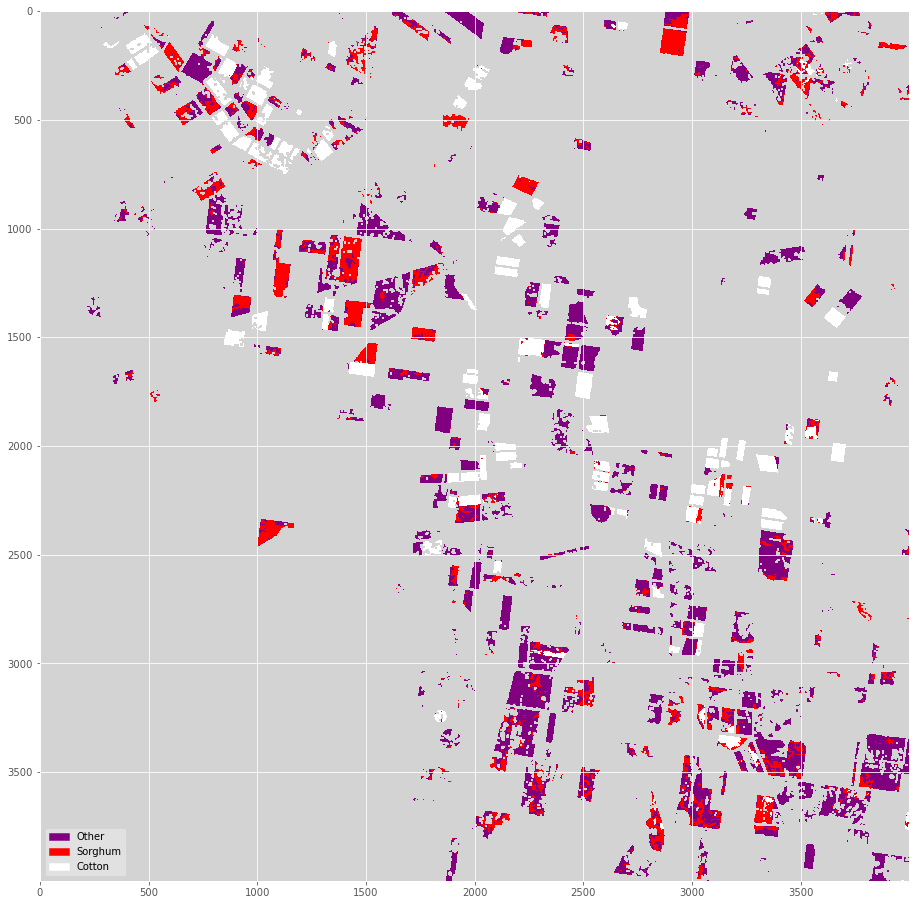

In [30]:
plt.style.use('ggplot')

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111)

values = list(label_mapper.values())
patches = [mpatches.Patch(color=colours[i], label="{l}".format(l=values[i]) ) for i in range(len(values))]
plt.legend(handles=patches, loc='lower left')

ax.imshow(inf_im, cmap=cmap_ag, aspect='equal')

plt.savefig('Inference.png', dpi=300, bbox_inches='tight')